In [11]:
%load_ext autoreload
%autoreload 2

import os
import json
import wandb
import argparse

import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode


from pytorch_metric_learning import distances, losses, miners, reducers, testers
from dataset import StreetHazardDataset, PadToMultipleOf16, StreetHazardDatasetTriplet

from model_new import DinoMetricLearning, DinoUpsampling, DinoSegmentation
from train import train_metric_learning
from loss import FixedWeighting, NormalizedWeighting, UncertaintyWeighting

from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

COLAB = False
KAGGLE = False
NUM_CLASSES = 13
SEED = 42
ORIGINAL_IMAGE_SIZE = (720, 1280)

# Seed everything
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [36]:
SCALE_FACTOR = 1
PREPROCESS = "resize"
BATCH_SIZE = 1
NUM_WORKERS = 2
DINO_REPO = "./dinov3"
CNN_OUT_DIM = 16
EMBEDDING_DIM = 256

In [31]:
image_size = PadToMultipleOf16().convert_dims(
    (ORIGINAL_IMAGE_SIZE[0] * SCALE_FACTOR, ORIGINAL_IMAGE_SIZE[1] * SCALE_FACTOR)
)

if KAGGLE:
    annotations_train_file = "/kaggle/input/streethazards-train/train/train.odgt"
    annotation_val_file = "/kaggle/input/streethazards-train/train/validation.odgt"
    annotation_test_file = "/kaggle/input/streethazards-test/test/test.odgt"
    img_dir = "/kaggle/input/streethazards-train/train/"
    img_dir_test = "/kaggle/input/streethazards-test/test/"
else:
    annotations_train_file = "./data/train/train.odgt"
    annotation_val_file = "./data/train/validation.odgt"
    annotation_test_file = "./data/test/test.odgt"
    img_dir = "./data/train/"
    img_dir_test = "./data/test/"

if PREPROCESS == "resize":
    image_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(image_size, interpolation=InterpolationMode.BICUBIC),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    )

    target_transform = transforms.Compose(
        [
            transforms.Resize(image_size, interpolation=InterpolationMode.NEAREST),
        ]
    )
elif PREPROCESS == "crop":
    image_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomCrop(image_size),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    )

    target_transform = transforms.Compose(
        [
            transforms.RandomCrop(image_size),
        ]
    )

dataset_train = StreetHazardDataset(
    annotations_train_file,
    img_dir,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=False,
)

dataset_val = StreetHazardDataset(
    annotation_val_file,
    img_dir,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=False,
)

dataset_test = StreetHazardDataset(
    annotation_test_file,
    img_dir_test,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=False,
)

dl_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
dl_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() and NUM_WORKERS > 0 else False,
)

# Data Exploration

The dataset used for this assignment is the [Street Hazards](https://arxiv.org/abs/1911.11132) dataset, which is a synthetic dataset designed for anomaly detection in street scenes. The dataset contains images of street scenes with various types of anomalies, such as unusual objects or unexpected events.

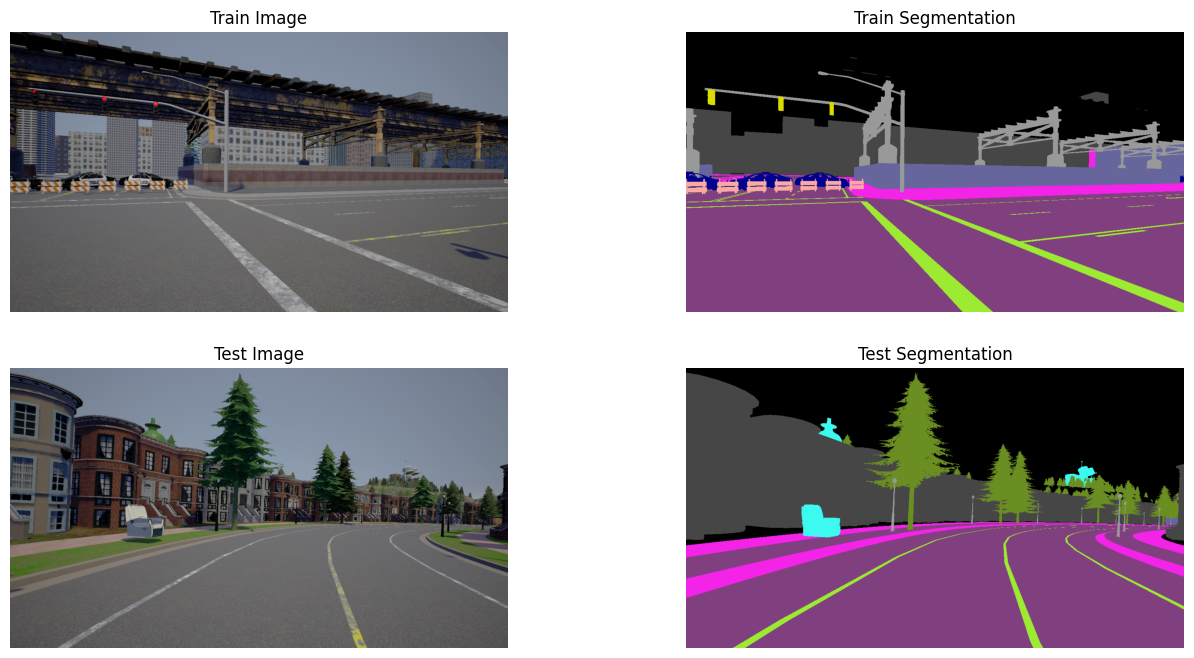

In [32]:
from plot import color, de_normalize
import matplotlib.pyplot as plt

INDEX = 2
train_image, train_segmentation = dataset_train[INDEX]
test_image, test_segmentation = dataset_test[INDEX]

plt.figure(figsize=(16,8))
plt.subplot(2,2, 1)
plt.title("Train Image")
plt.imshow(de_normalize(train_image).permute(1, 2, 0))
plt.axis('off')
plt.subplot(2,2, 2)
plt.title("Train Segmentation")
plt.imshow(color(train_segmentation))
plt.axis('off')
plt.subplot(2,2, 3)
plt.title("Test Image")
plt.imshow(de_normalize(test_image).permute(1, 2, 0))
plt.axis('off')
plt.subplot(2,2, 4)
plt.title("Test Segmentation")
plt.imshow(color(test_segmentation))
plt.axis('off')
plt.show()

As visible from the examples above, the anomalies are present only in the test set (highlighted in cyan).

# Open-World Semantic Segmentation Approach

The task of this assignment is to perform open-world semantic segmentation, which involves segmenting images into known classes while also identifying and segmenting unknown or anomalous objects (as a new unseen class).
The particular challenge of this task is that the model does not have access to any examples of the unknown classes during training, and must rely on its ability to generalize from the known classes to identify and segment the unknown classes.
The proposed approach is the following:
- Use a foundation model (DINOv3) to extract features from the images.
- Train a segmentation head using two losses:
  - Cross-entropy loss for the known classes.
  - A metric learning loss (e.g., contrastive loss) to encourage the model to learn a feature space where known classes are well-separated.
- During inference, use the logits from the segmentation head to identify unknown classes by thresholding the maximum softmax probability.

# Model

![Alt text](./ML4CV%20Diagram.drawio.svg)

The model consists of the following components:
1. **Frozen backbone**: A pre-trained [DINOv3](https://github.com/facebookresearch/dinov3) model is used as a feature extractor. The model is frozen during training to leverage the rich feature representations learned from large-scale data.
2. **Small CNN**: A small CNN takes the input image and extracts low level, but high-resolution features. These features are then summed with the features from the DINOv3 backbone to provide both high-level and low-level information to the segmentation head.
3. **Segmentation head**: A simple $1 \times 1$ convolutional layer is used as the segmentation head. This layer takes the combined features from the backbone and the small CNN and produces logits for each class (excluding the unknown class).
4. **Anomaly Detector**: Use [energy based](https://arxiv.org/abs/2010.03759) method to identify anomalies. The energy score is computed from the logits produced by the segmentation head.

In [37]:
backbone = torch.hub.load(
    DINO_REPO,
    "dinov3_vits16",
    source="local",
    weights="https://dinov3.llamameta.net/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiOHppYnI1MjB4NzVzNGZxbXpodTVnbndzIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTY5MTUxNDF9fX1dfQ__&Signature=Xw7TaFMGn3Z7y9Y12-R1virV1ZQPfblWOGr-7wBgcxwMkNj3NvuXC18tN%7ERAbvKKGNQgvXPBQoVc1XfAvphfUOXQi7tqCt2RbLojJlelfnwDnN0QoqhnMLWUgAXHhDc0VyqQcrXYAy44mx8dqyIVGLH37ca0196hdIoXutZEtnrtnLHqhr9-QR2qsOkwV0yl0oUGoATHwvDb8W1ChnkVoS0t08LogKZd1likEx25ZIW5g2FM2IMfpyyiV8Z5-DOQythF4eeocyqMJHFpqhI7pBgUDRyji3daJQzB6PefNvEda7G6g30rVzEj5FTFdXAOR4favjoGKa%7Eh1x5OePLhlw__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1292726919301558",
).to(device)
feature_extractor = DinoMetricLearning(
    backbone,
    dino_out_dim=None,
    cnn_out_dim=CNN_OUT_DIM,
    out_dim=EMBEDDING_DIM,
).to(device)
model = DinoSegmentation(
    feature_extractor,
    num_classes=NUM_CLASSES,
).to(device)

An alternative model without the small CNN (denoted `model_upsampling`) is also implemented to evaluate the impact of low-level features on the performance.

In [39]:
model_upsampling = DinoSegmentation(
    DinoUpsampling(
        backbone, out_dim=EMBEDDING_DIM
    ),
    num_classes=NUM_CLASSES,
).to(device)

# Model Evaluation

In [ ]:
# Load the weights
model.load_state_dict(torch.load("./best_model.pth"))

# Structure
## Data exploration
## Approaches
## Model evaluation
## Ablation study
## Conclusion